<a href="https://colab.research.google.com/github/WenzelArifiandi/kestrel/blob/main/Kestrel%2BModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kestrel+Model
### A [Bangkit 2021](https://grow.google/intl/id_id/bangkit/) Capstone Project

Kestrel is a TensorFlow powered American Sign Language translator Android app that will make it easier for anyone to seamlessly communicate with people who have vision or hearing impairments. The Kestrel model builds on the state of the art MobileNetV2 model that is optimized for speed and latency on smartphones to accurately recognize and interpret sign language from the phone’s camera and display the translation through a beautiful, convenient and easily accessible Android app.

# American Sign Language 
Fingerspelling alphabets
from the [National Institute on Deafness and Other Communication Disorders (NIDCD)](https://www.nidcd.nih.gov/health/american-sign-language-fingerspelling-alphabets-image) 

<table>
  <tr><td>
    <img src="https://www.nidcd.nih.gov/sites/default/files/Content%20Images/NIDCD-ASL-hands-2019_large.jpg"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://www.nidcd.nih.gov/health/american-sign-language-fingerspelling-alphabets-image">ASL Fingerspelling Alphabets</a> <br/>&nbsp;
  </td></tr>
</table>

# Initial setup

In [2]:
try:
    %tensorflow_version 2.x
except:
    pass

import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import PIL
import PIL.Image
from os import listdir

import pathlib

from tqdm import tqdm
from tensorflow.keras.preprocessing import image_dataset_from_directory

print("\u2022 Using TensorFlow Version:", tf.__version__)
print("\u2022 Using TensorFlow Hub Version: ", hub.__version__)
print('\u2022 GPU Device Found.' if tf.config.list_physical_devices('GPU') else '\u2022 GPU Device Not Found. Running on CPU')


• Using TensorFlow Version: 2.5.0-rc3
• Using TensorFlow Hub Version:  0.9.0
• GPU Device Not Found. Running on CPU


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


# Data preprocessing

### (Optional) Unzip file on Google Drive

In [ ]:
import zipfile
import pathlib
zip_dir = pathlib.Path('/content/drive/Shareddrives/Kestrel/A - Copy.zip')
unzip_dir = pathlib.Path('/content/drive/Shareddrives/Kestrel/A_Unzipped')
with zipfile.ZipFile(zip_dir, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

### Loading images from Google Drive

In [ ]:
data_dir = pathlib.Path('/content/drive/Shareddrives/Kestrel/A_Unzipped/A - Copy')

(Optional) Counting the number of images in the dataset

In [ ]:
image_count = len(list(data_dir.glob('*/color*.png')))
print(image_count)

12547


(Optional) Displaying one of the "a" letter sign language image:

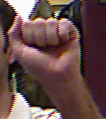

In [ ]:
two = list(data_dir.glob('*/color*.png'))
PIL.Image.open(str(two[0]))

# Create the dataset

Loading the images off disk using [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory). Define some parameters for the loader:

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

### Coursera method using ImageDataGenerator

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',
      validation_split=0.2)
validation_generator = ImageDataGenerator(
      rescale = 1./255,
      validation_split=0.2)
train_dataset = train_generator.flow_from_directory(data_dir,
                                                    batch_size = BATCH_SIZE,
                                                    class_mode = 'categorical',
                                                    subset='training', 
                                                    target_size = IMG_SIZE,
                                                    )
validation_dataset = validation_generator.flow_from_directory(data_dir,
                                                    batch_size = BATCH_SIZE,
                                                    class_mode = 'categorical',
                                                    subset='validation', 
                                                    target_size = IMG_SIZE,
                                                    )

Found 10046 images belonging to 24 classes.
Found 2501 images belonging to 24 classes.


Splitting images for training and validation

In [ ]:
#@title Unused 
train_dataset = image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  shuffle=True,
  labels='inferred',
  label_mode='int',
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 12547 files belonging to 24 classes.
Using 10038 files for training.


In [ ]:
#@title Unused
validation_dataset = image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  shuffle=True,
  labels='inferred',
  label_mode='int',
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 12547 files belonging to 24 classes.
Using 2509 files for validation.


In [ ]:
#@title Unused
class_names = train_dataset.class_names
print(class_names)

### (Optional) Visualize the data

Show the first 9 images and labels from the training set:

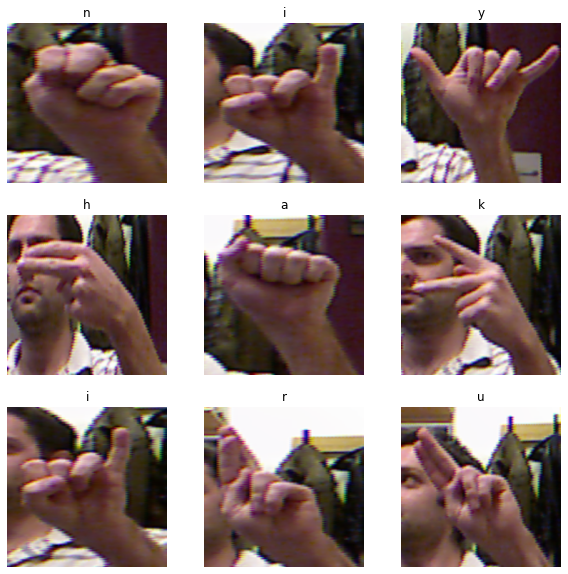

In [ ]:
#@title Showing 9 images
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


### (Optional) Create a test set

To create a Test Set, determine how many batches of data are available in the validation set using ```tf.data.experimental.cardinality```, then move 20% of them to a test set.

In [ ]:
validation_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(validation_batches // 5)
validation_dataset = validation_dataset.skip(validation_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 64
Number of test batches: 15


### (Unused) Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### (Unused) Use data augmentation
When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

Note: These layers are active only during training, when you call `model.fit`. They are inactive when the model is used in inference mode in `model.evaulate` or `model.fit`. Let's repeatedly apply these layers to the same image and see the result.

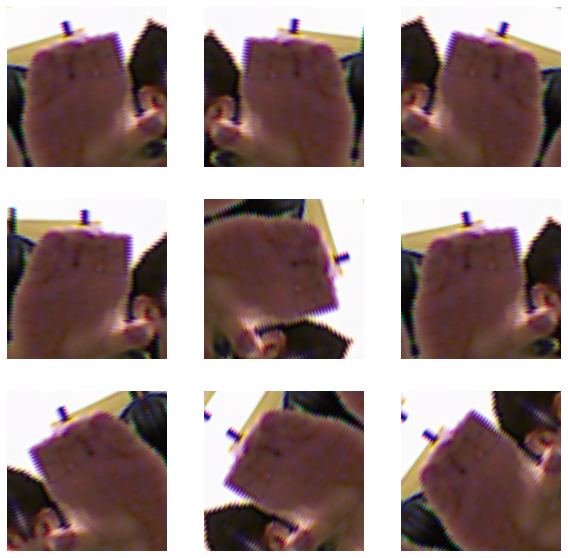

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### (Unused) Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel values in `[-1,1]`, but at this point, the pixel values in your images are in `[0-255]`. To rescale them, use the preprocessing method included with the model.

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful.  Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


This feature extractor converts each `224 x 224` image into a `7x7x1280` block of features. Let's see what it does to an example batch of images:

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


# Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base
It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

# Coursera Method

In [ ]:
last_layer = base_model.get_layer('out_relu')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 1280)


In [ ]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
from tensorflow.keras import Model
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (24, activation='softmax')(x)           

model = Model( base_model.input, x) 
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer='rmsprop', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])
history = model.fit(train_dataset, epochs=10, steps_per_epoch=20, validation_data = validation_dataset, verbose = 1, validation_steps=3)

Epoch 1/10
20/20 [==============================] - 300s 15s/step - loss: 163.2098 - accuracy: 0.1144 - val_loss: 8.6906 - val_accuracy: 0.3438
Epoch 2/10
20/20 [==============================] - 261s 13s/step - loss: 11.6045 - accuracy: 0.2889 - val_loss: 3.3387 - val_accuracy: 0.4167
Epoch 3/10
20/20 [==============================] - 248s 13s/step - loss: 3.5982 - accuracy: 0.3176 - val_loss: 2.4997 - val_accuracy: 0.2604
Epoch 4/10
20/20 [==============================] - 230s 12s/step - loss: 4.2812 - accuracy: 0.2593 - val_loss: 2.7110 - val_accuracy: 0.3958
Epoch 5/10
20/20 [==============================] - 214s 11s/step - loss: 3.1995 - accuracy: 0.3384 - val_loss: 2.6585 - val_accuracy: 0.2812
Epoch 6/10
20/20 [==============================] - 209s 10s/step - loss: 3.1496 - accuracy: 0.3343 - val_loss: 2.9670 - val_accuracy: 0.2708
Epoch 7/10
20/20 [==============================] - 193s 10s/step - loss: 2.6831 - accuracy: 0.3897 - val_loss: 1.7645 - val_accuracy: 0.4688
Epo

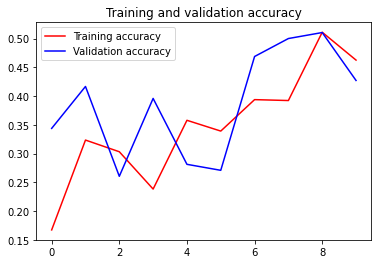

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
#@title Unused
model.compile(optimizer = 'rmsprop', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])
history = model.fit(train_dataset, epochs=25, steps_per_epoch=20, validation_data = validation_dataset, verbose = 1, validation_steps=3)

### Add a classification head
To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. 

In [ ]:
prediction_layer = tf.keras.layers.Dense(24)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 24)


Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
Compile the model before training it. Since there are 24 classes, use a categorical cross-entropy loss with `from_logits=True` since the model provides a linear output.

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0   

The 2.5M parameters in MobileNet are frozen, but there are 1.2K _trainable_ parameters in the Dense layer.  These are divided between two `tf.Variable` objects, the weights and biases.

In [ ]:
len(model.trainable_variables)

2

# Train the model
After training for 10 epochs, you should see ~94% accuracy on the validation set.

In [ ]:
initial_epochs = 10
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10


ValueError: ignored

# Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we will standardize values to be in the `[0, 1]` by using the `tf.image` module to format the images for the task.

Resize the images to a fixes input size, and rescale the input channels

In [ ]:
def format_image(image, class_names):
    image = tf.image.resize(image, IMAGE_SIZE) / 255.0
    return  image, class_names

In [ ]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.003921569 0.9960785


Now shuffle and batch the data

In [ ]:
BATCH_SIZE = 32 #@param {type:"integer"}

In [ ]:
for image_batch, labels_batch in train_dataset:
  images = tf.convert_to_tensor(images, dtype=tf.uint8)
  break

ValueError: ignored

In [ ]:
# Prepare the examples by preprocessing the them and then batching them (and optionally prefetching them)
num_examples = image_count


# If you wish you can shuffle train set here
train_batches = train_dataset.shuffle(num_examples // 4).batch(BATCH_SIZE).map(format_image).prefetch(1) # YOUR CODE HERE

validation_batches = validation_ds.batch(BATCH_SIZE).map(format_image).prefetch(1) # YOUR CODE HERE

test_batches = test_examples.batch(1).map(format_image) # YOUR CODE HERE

ValueError: ignored

In [ ]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

NameError: ignored

# Defining the model

In [ ]:
do_fine_tuning = False #@param {type:"boolean"}

In [ ]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,), 
                                   output_shape=[FV_SIZE],trainable=do_fine_tuning
                    )

In [ ]:
print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(24, activation='softmax')
])

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_2 (Dense)              (None, 24)                30744     
Total params: 2,288,728
Trainable params: 30,744
Non-trainable params: 2,257,984
_________________________________________________________________


# Training the Model

In [ ]:
if do_fine_tuning:
    model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.002, momentum=0.9),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
else:
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
input_tensor = tf.convert_to_tensor(np.expand_dims(image, 0), dtype=tf.float32)

NameError: ignored

In [ ]:

train_batches = train_dataset.batch(BATCH_SIZE).map(format_image).prefetch(1)
validation_batches = validation_dataset.batch(BATCH_SIZE).map(format_image).prefetch(1)

ValueError: ignored

In [ ]:
EPOCHS = 5

hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches)

Epoch 1/5


ValueError: ignored